In [29]:
using MPSTime
using Random
using Plots
using PrettyTables
using ITensors

rng = Xoshiro(1)

opts = MPSOptions(d = 3, chi_max = 10, sigmoid_transform = false)

ntimepoints = 10
ntrain_instances = 1000
ntest_instances = 500
period = 10
sigma = 0.1;

In [18]:
function AngleEncoder(x::Float64)
    if x <= 1 && x >= 0
        return [cos(pi/2 * x), sin(pi/2 * x)]
    else
        println("Check Data Normilisation")
    end
end;

In [20]:
global LocalParameters = Dict(
    :feature_map => AngleEncoder,
    :num_mps_sites => 0,
    :local_dimension => 2,
    :chi_init => 5,
    :random_state => 42,
    :num_classes => 1,
)

Dict{Symbol, Any} with 6 entries:
  :local_dimension => 2
  :num_mps_sites   => 0
  :chi_init        => 5
  :feature_map     => AngleEncoder
  :random_state    => 42
  :num_classes     => 1

In [6]:
X_train, _ = trendy_sine(ntimepoints, ntrain_instances; sigma = sigma, rng = rng,slope = 0, period = period);
X_test, _ = trendy_sine(ntimepoints, ntest_instances; sigma = sigma, rng = rng,slope = 0, period = period);

In [24]:
function NormaliseSample(sample::Vector)
    return (sample.- minimum(sample)) ./ maximum(sample)
end

NormaliseSample (generic function with 1 method)

In [8]:
function twoD_feature_map(x::Float64)
	state = Vector{Float64}([cos(pi / 2 * x), sin(pi / 2 * x)])
	return state
end

twoD_feature_map (generic function with 1 method)

In [38]:
function adlegendre_feature_map(x::Float64, dim::Int64, norm=true)
    """ N states mapping """

    state = Array{Float64, 1}(undef, dim)
    state[1] = 1
    state[2] = x
    for i in 3:dim
        state[i] = ((2 * i - 1) * x * state[i-1] - (i - 1) * state[i-2]) / i
    end

    if (norm == true)
        state = sqrt(dim + 0.5) .* state
    end

    return state
end  

adlegendre_feature_map (generic function with 3 methods)

In [ ]:
function GenerateProductStates(sample::Vector, params::Dict=Local_Parameters)
    N_sites = params[:num_mps_sites]
    site_inds = params[:site_inds]
    feature_map = params[:feature_map]
    d = params[:local_dimension]

    normalised_sample = NormaliseSample(sample)
        
    product_state = MPS(site_inds; linkdims = 1)

    if N_sites !== size(normalised_sample)[1]
        println("Size issue")
    end
    

    for j = 1:N_sites
        T = ITensor(site_inds[j])
        mapped_vals = feature_map(normalised_sample[j])
        


Base.Meta.ParseError: ParseError:
# Error @ /home/lukas/Documents/GitHub/Stationary-MPS-Honours/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:9:35
        
    product_state = MPS(site_inds)
#                                 └ ── Expected `end`

In [7]:
mps, info, test_states = fitMPS(X_train, opts);

Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.
Using 1 iterations per update.
Training KL Div. 12.134177220166327 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/5]
Backward sweep finished.
Starting forward sweep: [1/5]
Finished sweep 1. Time for sweep: 34.19s
Training KL Div. 7.7295538337188905 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/5]
Backward sweep finished.
Starting forward sweep: [2/5]
Finished sweep 2. Time for sweep: 0.49s
Training KL Div. 5.865779902007335 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/5]
Backward sweep finished.
Starting forward sweep: [3/5]
Finished sweep 3. Time for sweep: 0.46s
Training KL Div. 4.803562785505739 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [4/5]
Back

In [8]:
class = 0
instance_idx = 10
impute_sites = [ntimepoints]
method = :median
imp = init_imputation_problem(mps,X_test);

Initialising train states.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 1000 training samples and 500 testing samples.
Slicing MPS into individual states...
 - 1 class(es) were detected.
 - Time independent encoding - Legendre - detected.
 - d = 3, chi_max = 10
Re-encoding the training data to get the encoding arguments...

 Created 1 ImputationProblem struct(s) containing class-wise mps and test samples.


In [12]:
imputed_ts, pred_err, target_ts, stats, nice_plots = MPS_impute(imp, class, instance_idx, impute_sites, method; plot_fits = true);

In [13]:
pretty_table(stats[1]; header = ["Metric", "Value"], header_crayon = crayon"yellow bold", tf = tf_unicode_rounded)

╭─────────┬───────────╮
│  Metric │     Value │
├─────────┼───────────┤
│     MAE │ 0.0621272 │
│    MAPE │  0.158488 │
│  NN_MAE │ 0.0243582 │
│ NN_MAPE │ 0.0621382 │
╰─────────┴───────────╯


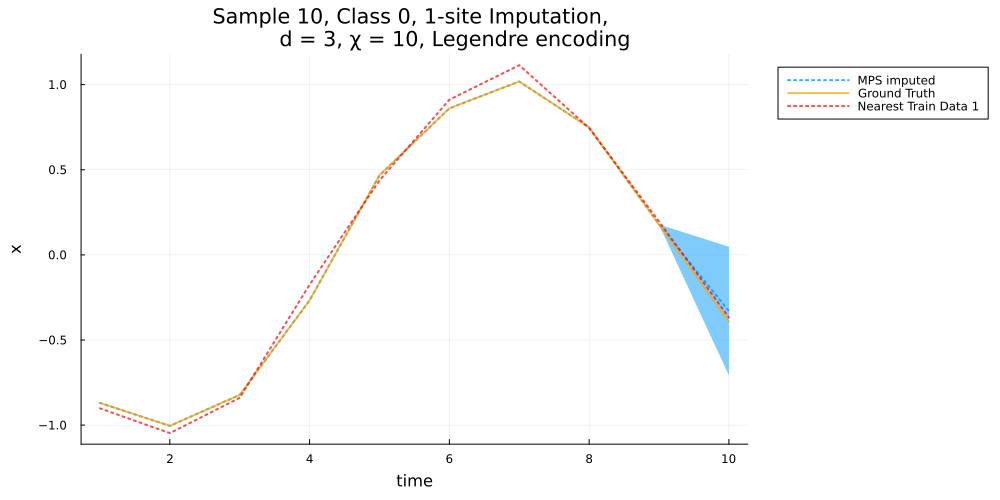

In [14]:
plot(nice_plots...)